In [1]:
# Import necessary libraries
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [2]:
# Set seeds for reproducibility
seed_value = 42
tf.random.set_seed(seed_value)
np.random.seed(seed_value)
random.seed(seed_value)

In [3]:
# Check if GPU is available and set up memory growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Enable memory growth for GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"TensorFlow is using GPU: {tf.config.list_physical_devices('GPU')}")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU detected. TensorFlow will use the CPU.")

No GPU detected. TensorFlow will use the CPU.


In [4]:
img_height, img_width = 224, 224
batch_size = 30

# Load training, validation and test dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    r"train",
    image_size = (img_height, img_width),
    batch_size = batch_size,
    seed=seed_value
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    r"val",
    image_size = (img_height, img_width),
    batch_size = batch_size,
    seed=seed_value
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    r"test",
    image_size = (img_height, img_width),
    batch_size = batch_size,
    seed=seed_value
)

Found 5000 files belonging to 10 classes.
Found 500 files belonging to 10 classes.
Found 500 files belonging to 10 classes.


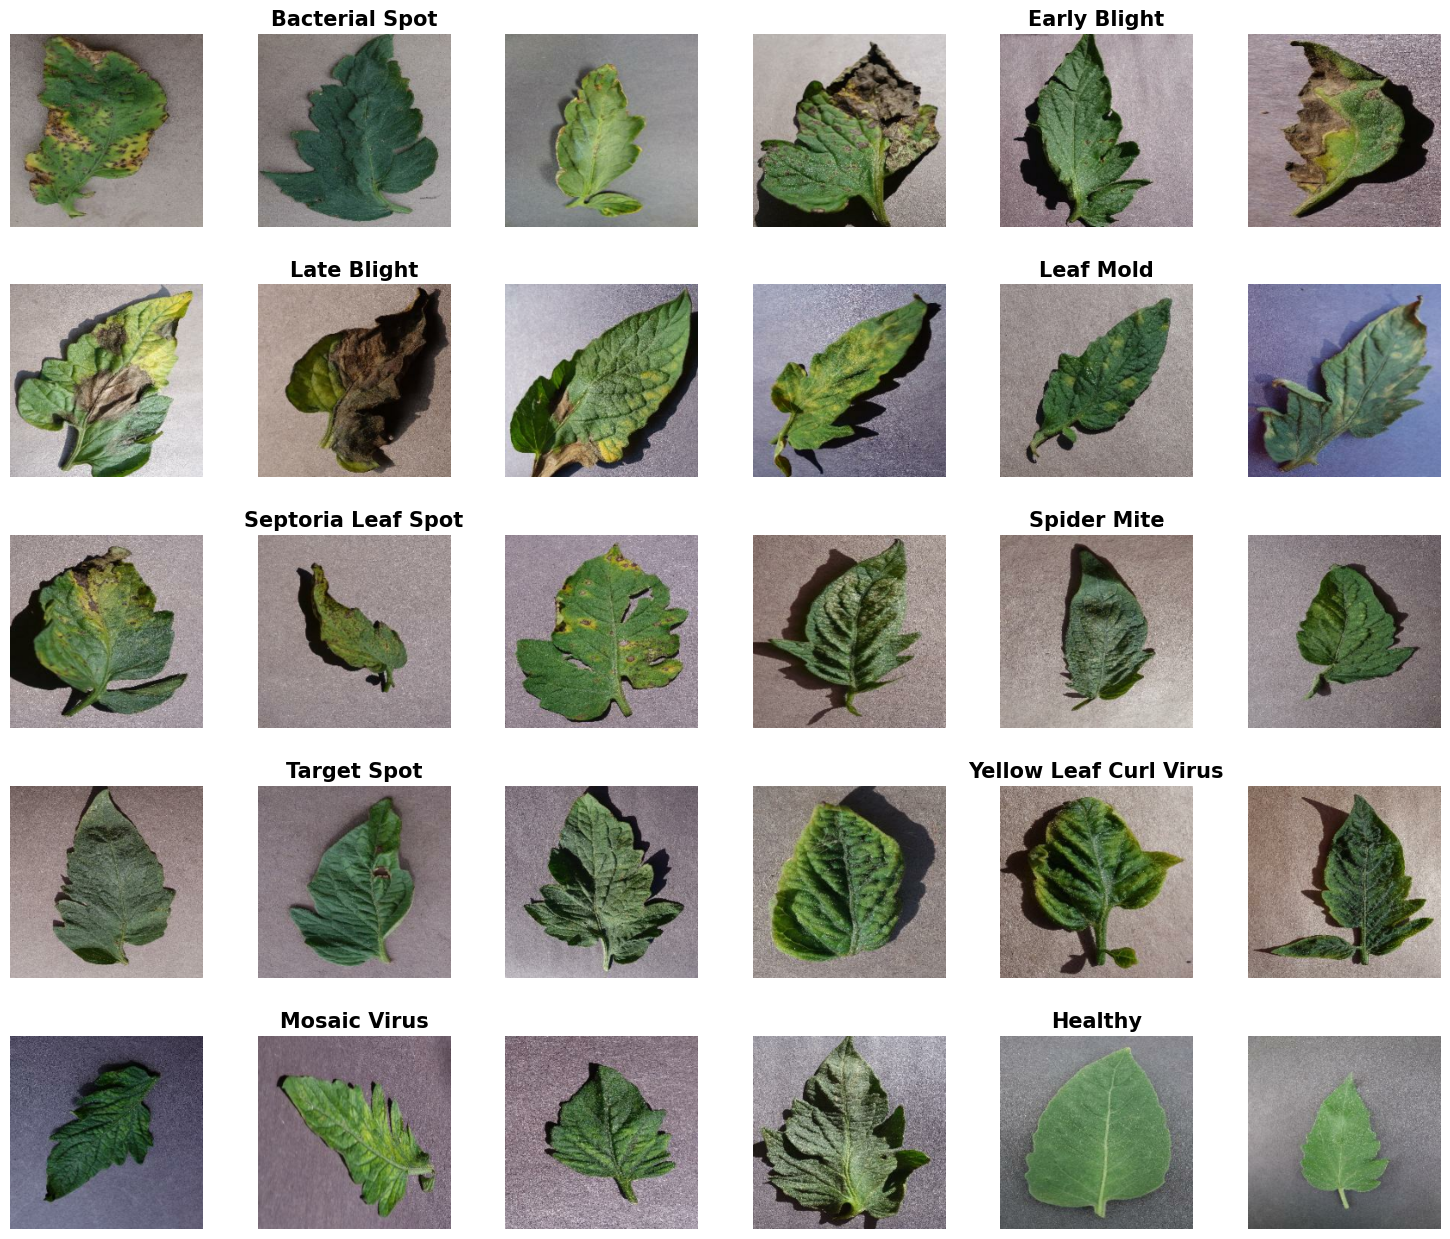

In [5]:
class_names = ["Bacterial Spot", "Early Blight", "Late Blight", "Leaf Mold", "Septoria Leaf Spot", "Spider Mite", "Target Spot", "Yellow Leaf Curl Virus", "Mosaic Virus", "Healthy"]

# Prepare a figure
plt.figure(figsize=(15, 15))

# Counter to track images per class
class_counters = {class_name: 0 for class_name in class_names}

# Loop through the dataset and display images
for images, labels in train_ds:
    for img, label in zip(images, labels):
        class_name = class_names[label]
        if class_counters[class_name] < 3:  # Display only 3 images per class
            idx = class_names.index(class_name) * 3 + class_counters[class_name] + 1
            plt.subplot(6, 6, idx)
            plt.imshow(img.numpy().astype("uint8"))
            if class_counters[class_name] == 1:  # Center title
                plt.title(class_name, fontsize=15, fontweight='bold')
            plt.axis("off")
            class_counters[class_name] += 1
        if all(count == 10 for count in class_counters.values()):  # Done if all classes have 10 images
            break
    if all(count == 10 for count in class_counters.values()):
        break

plt.tight_layout()
plt.subplots_adjust(hspace=0.3) 
plt.show()

In [6]:
model = tf.keras.Sequential(
    [
        # Normalize pixel values to the range [0, 1]
        tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

        # First convolutional layer followed by max-pooling
        tf.keras.layers.Conv2D(32, 3, activation="relu"),
        tf.keras.layers.MaxPooling2D(),

        # Second convolutional layer followed by max-pooling
        tf.keras.layers.Conv2D(32, 3, activation="relu"),
        tf.keras.layers.MaxPooling2D(),

        # Third convolutional layer followed by max-pooling
        tf.keras.layers.Conv2D(32, 3, activation="relu"),
        tf.keras.layers.MaxPooling2D(),

        # Flatten layer to convert 2D feature maps into 1D feature vectors
        tf.keras.layers.Flatten(),

        # Fully connected layer with 128 units and ReLU activation
        tf.keras.layers.Dense(128, activation="relu"),

        # Dropout layer with 30% drop
        tf.keras.layers.Dropout(0.3),

        # Output layer with 10 neurons (one for each class) and Softmax activation
        tf.keras.layers.Dense(10, activation="softmax")
    ]
)

# Compile the model
model.compile(
    optimizer='adam',  # Optimizer
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),  # Loss function
    metrics=['accuracy']  # Evaluation metric
)

# Print a summary of the model structure
model.summary()

c:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 21632)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,769,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,789,706 (10.64 MB)

 Trainable params: 2,789,706 (10.64 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore the weights of the best epoch after stopping
)

In [8]:
# Model training with EarlyStopping
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[early_stopping]
)

Epoch 1/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 39s 227ms/step - accuracy: 0.2859 - loss: 1.9410 - val_accuracy: 0.6380 - val_loss: 0.9924
Epoch 2/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 37s 218ms/step - accuracy: 0.6475 - loss: 1.0013 - val_accuracy: 0.7640 - val_loss: 0.7251
Epoch 3/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 37s 221ms/step - accuracy: 0.7087 - loss: 0.8175 - val_accuracy: 0.8180 - val_loss: 0.5590
Epoch 4/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 36s 217ms/step - accuracy: 0.7822 - loss: 0.6110 - val_accuracy: 0.8140 - val_loss: 0.4948
Epoch 5/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 37s 220ms/step - accuracy: 0.8298 - loss: 0.5067 - val_accuracy: 0.8220 - val_loss: 0.4926
Epoch 6/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 37s 223ms/step - accuracy: 0.8562 - loss: 0.4207 - val_accuracy: 0.7600 - val_loss: 0.6742
Epoch 7/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 37s 220ms/step - accuracy: 0.8616 - loss: 0.3948 - val_accuracy: 0.8180 - val_loss: 0.5524
Epoch 8/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 37s 221ms/step - accuracy: 0.8537 - loss: 0

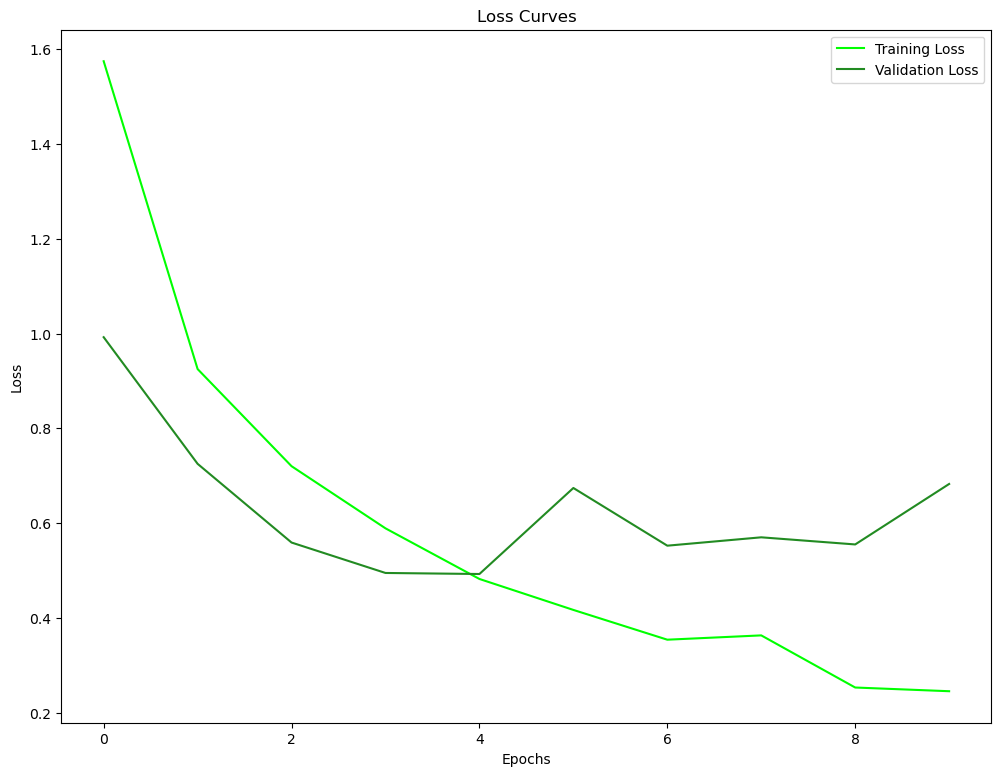

In [9]:
# Plot loss curves
plt.figure(figsize=(12, 9))
plt.plot(history.history['loss'], label='Training Loss', color="lime")
plt.plot(history.history['val_loss'], label='Validation Loss', color="forestgreen")
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

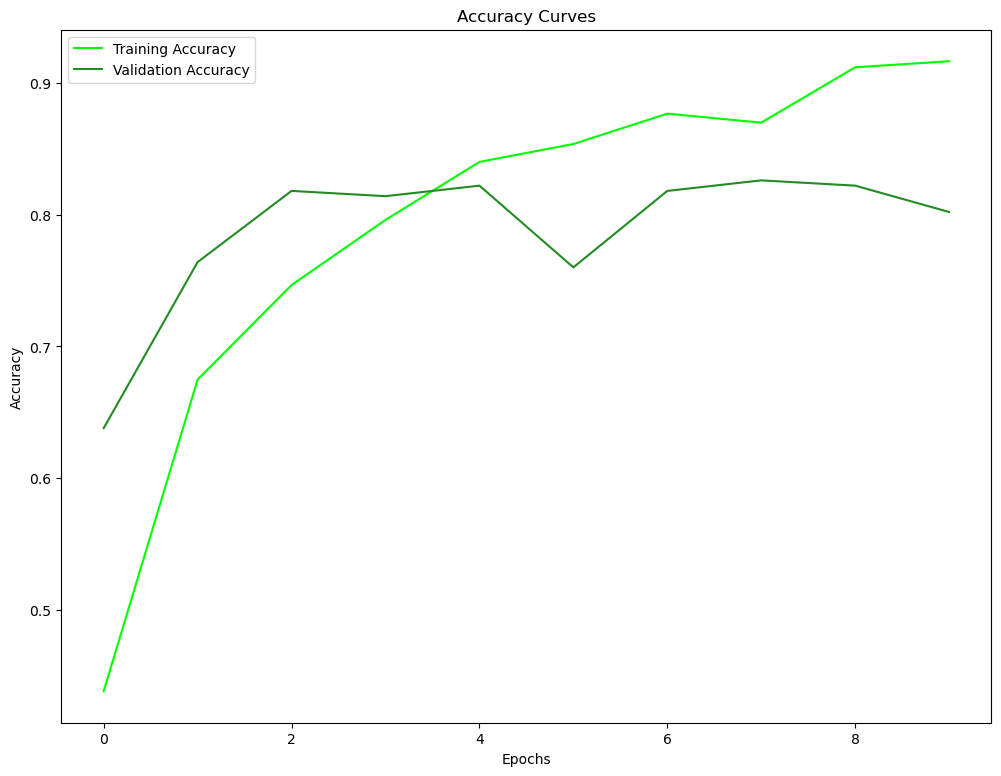

In [10]:
# Plot accuracy curves
plt.figure(figsize=(12, 9))
plt.plot(history.history['accuracy'], label='Training Accuracy', color="lime")
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color="forestgreen")
plt.title('Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [11]:
# Generate predictions
y_true = []  # True labels
y_pred = []  # Predicted labels

# Iterate over the validation dataset
for images, labels in val_ds:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
Classification Report:
                        precision    recall  f1-score   support

        Bacterial Spot       0.85      0.88      0.86        50
          Early Blight       0.80      0.64      0.71        50
           Late Blight       0.75      0.80      0.78        50
             Leaf Mold       0.95      0.70      0.80        50
    Sept

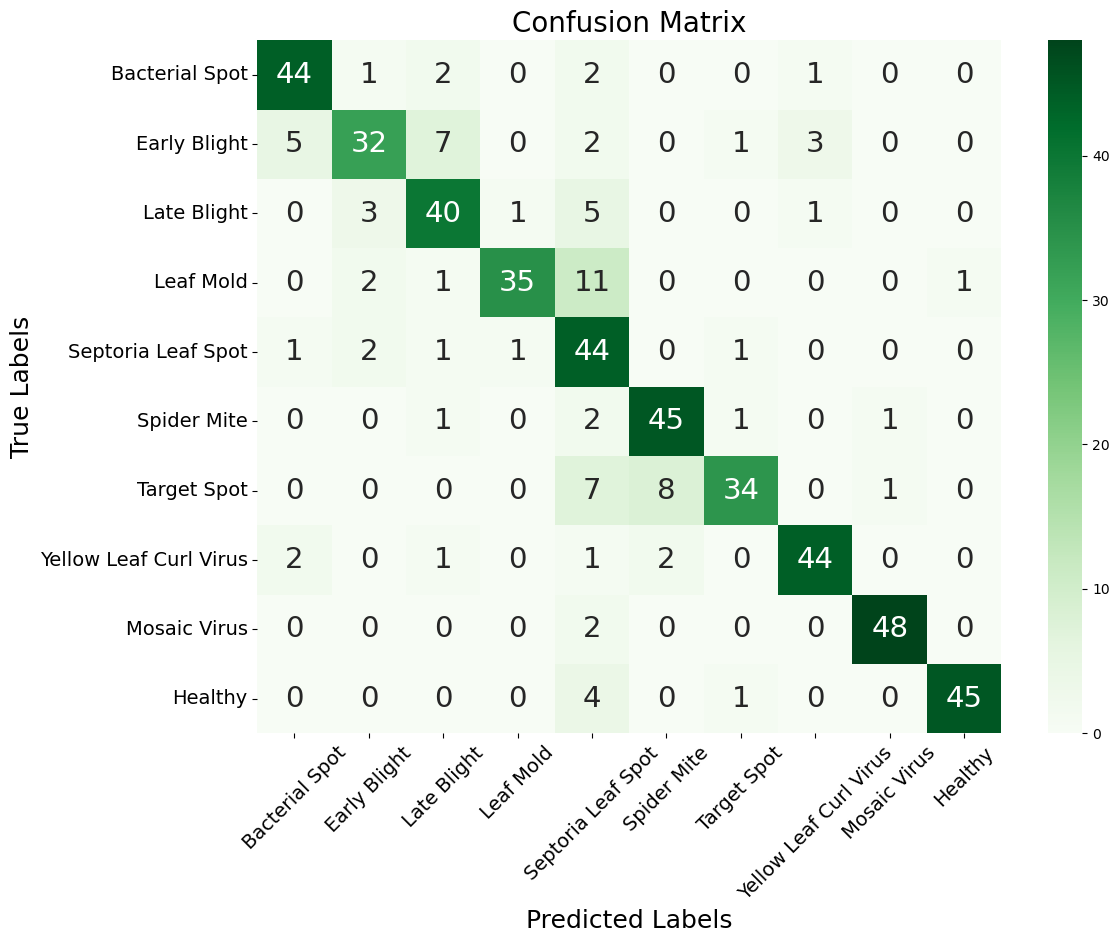

In [12]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 9))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=class_names, yticklabels=class_names,
            annot_kws={"size": 21})  # Increase annotation font size

# Increase label and title font sizes
plt.xlabel("Predicted Labels", fontsize=18)
plt.ylabel("True Labels", fontsize=18)
plt.title("Confusion Matrix", fontsize=20)

# Adjust tick labels' font size
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)

plt.show()


In [13]:
# Evaluate on test dataset
model.evaluate(test_ds)

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.8430 - loss: 0.5574


[0.6243012547492981, 0.8240000009536743]

In [14]:
for images, labels in test_ds.take(1):
  classifications = model(images)   # Get model predictions (classifications) for the batch of images
  print(classifications)   # Print raw classification outputs (logits or probabilities)

tf.Tensor(
[[9.92394090e-01 2.61628744e-03 3.50765011e-04 7.53098138e-05
  3.73981660e-03 2.76187347e-06 3.96890566e-04 2.59802619e-04
  5.54243904e-08 1.64260695e-04]
 [2.31228000e-07 6.69326764e-05 1.26849579e-06 7.15454519e-07
  3.76480544e-04 3.72819050e-04 9.91306007e-01 4.27762478e-11
  3.29025738e-07 7.87517335e-03]
 [2.64522765e-04 3.18185277e-02 3.79744284e-02 5.27843118e-01
  3.68309438e-01 2.92711495e-03 5.28302882e-03 1.26565863e-06
  2.39976260e-04 2.53385957e-02]
 [4.39315476e-03 1.29768625e-02 1.22823790e-01 2.70916685e-03
  5.15193224e-01 3.18228304e-01 1.07038561e-02 7.85581395e-03
  7.16362672e-04 4.39945841e-03]
 [9.05866215e-11 6.50815480e-07 6.11038058e-06 2.07472171e-04
  3.46828960e-02 2.05566857e-06 7.62659693e-05 1.96717167e-08
  9.65023100e-01 1.45301283e-06]
 [9.86419618e-01 4.50368924e-03 7.20666256e-04 4.06280742e-04
  2.75564799e-03 8.65668608e-06 4.32577450e-04 3.66765237e-03
  4.44133093e-07 1.08487776e-03]
 [1.35573353e-09 2.35310818e-05 5.18242450e-06 

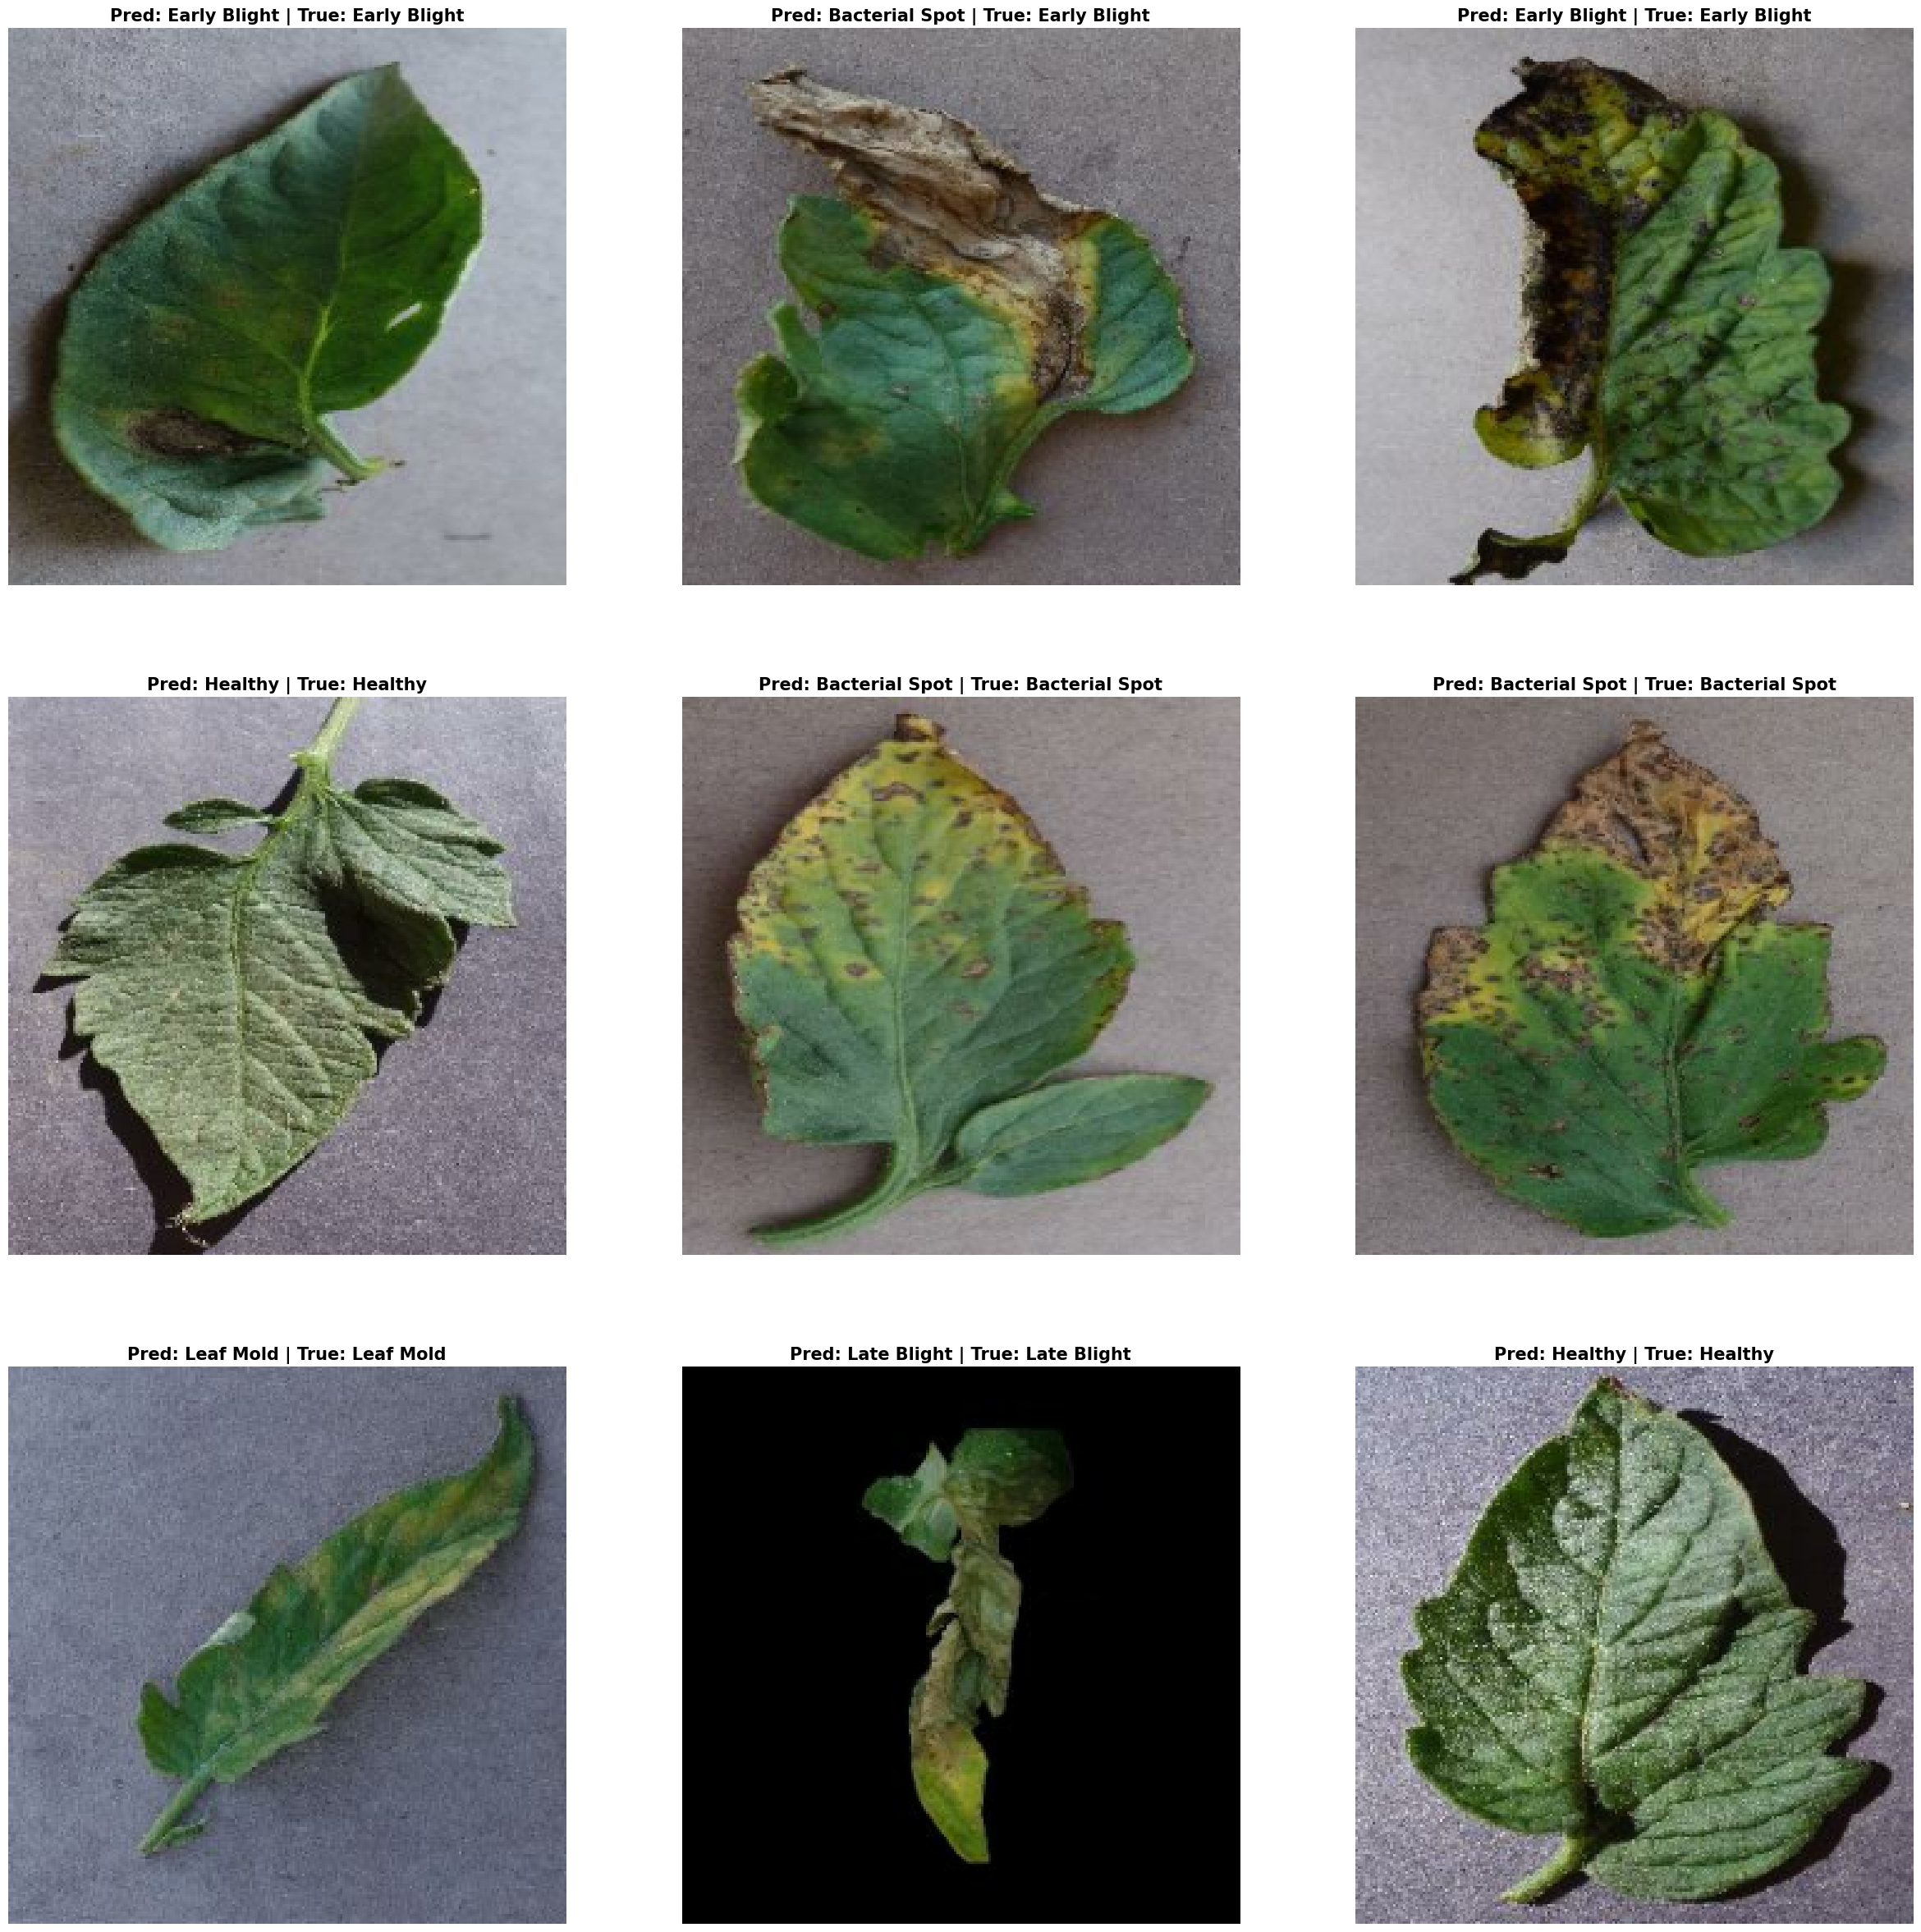

In [15]:
# Randomize indices for images and labels
random_indices = np.random.choice(len(images), 9, replace=False)

plt.figure(figsize=(30, 30))
for i, idx in enumerate(random_indices):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[idx].numpy().astype("uint8"))
    index = np.argmax(classifications[idx])   # Get the predicted class index (with the highest probability)
    plt.title(
        f"Pred: {class_names[index]} | True: {class_names[labels[idx]]}",
        fontsize=15,
        fontweight="bold"
    )
    plt.axis("off")

plt.show()

In [16]:
# Save the trained model in .keras format
model.save("tomato-model.keras")

# Convert trained Keras model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("tomato-model.tflite", 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\adzim\AppData\Local\Temp\tmpvvrflqhs\assets


INFO:tensorflow:Assets written to: C:\Users\adzim\AppData\Local\Temp\tmpvvrflqhs\assets


Saved artifact at 'C:\Users\adzim\AppData\Local\Temp\tmpvvrflqhs'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  1463202232272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1463202234000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1463202234192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1463202233808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1463202233616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1463202232464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1463308026320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1463308027664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1463308028048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1463308029008: TensorSpec(shape=(), dtype=tf.resource, name=None)
